## CTCF & H3K9me3 enrichment analysis
### Annie Maslan
### 06.28.21

In [1]:
import os
import numpy as np
import pandas as pd

# plotting & display imports
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
out = 'out'

## K9me3

In [3]:
data = pd.read_csv('k9me3_enrich.csv')
data.head()

,target,cell type,total A genome-wide,total A in chip/cut&run peaks,total A in centromeres,mA genome-wide,mA in chip/cut&run,mA in centromeres,mA/A genome-wide,mA/A in chip/cut&run,...,mA/A in centromere over mA/A genome-wide,ELISA mA/A,nanopore/ELISA,total A in cut&run + 10kb,mA in cut&run + 10kb,mA/A in peak target over mA/A in non-target (outside peak + 10kb),total A in HOR,mA in HOR,mA/A in HOR,mA/A in HOR over mA/A outside centromeres
0,H3K9me3,HG002,1801261088,46649090,181677009,1839964,147975,383916,0.001021,0.003172,...,2.351,0.00161,0.63,704157660,1168872,5.185739,23776193,94738,0.003985,4.432102
1,IgG,HG002,725052981,17943599,69359359,75843,2278,7981,0.000105,0.000127,...,1.112,0.00013,0.80,270234203,29775,1.253381,7870638,821,0.000104,1.007877
2,free pA-Hia5,HG002,1570216096,37645338,143701542,2490153,58185,177683,0.001586,0.001546,...,0.763,0.00356,0.45,583702075,887325,0.951297,17117383,7384,0.000431,0.266106


In [4]:
data.columns

Index(['target', 'cell type', 'total A genome-wide',
       'total A in chip/cut&run peaks', 'total A in centromeres',
       'mA genome-wide', 'mA in chip/cut&run', 'mA in centromeres',
       'mA/A genome-wide', 'mA/A in chip/cut&run', 'mA/A in centromeres',
       'mA/A in target over mA/A not in peaks',
       'mA/A in centromere over mA/A genome-wide', 'ELISA mA/A',
       'nanopore/ELISA', 'total A in cut&run + 10kb', 'mA in cut&run + 10kb',
       'mA/A in peak target over mA/A in non-target (outside peak + 10kb)',
       'total A in HOR', 'mA in HOR', 'mA/A in HOR',
       'mA/A in HOR over mA/A outside centromeres'],
      dtype='object')

In [5]:
#Give a uniform prior for methylation protportion. proportion p is distributed as Beta(1+mA, 1+(A-mA)) for each.
def calculate_ci(total_A_genome_wide, total_A_target, total_A_remove, mA_genome_wide, mA_target, mA_remove):
    g_total = total_A_genome_wide - total_A_remove
    g_mA = mA_genome_wide - mA_remove
    print((mA_target/total_A_target)/(g_mA/g_total))
    t = np.random.beta(1 + mA_target, 1 + (total_A_target - mA_target), size=100000)
    g = np.random.beta(1 + g_mA, 1 + (g_total - g_mA), size=100000)
    
    ratio = t/g
    
    ci_ratio_lower = np.percentile(ratio, 2.5)
    ci_ratio_upper = np.percentile(ratio, 97.5)
    
    return [ci_ratio_lower, ci_ratio_upper]

In [6]:
cmap = ['#610345','#559CAD', '#A9E5BB']

In [7]:
data['ci'] = data.apply(lambda row : calculate_ci(row['total A genome-wide'], row['total A in chip/cut&run peaks'], row['total A in cut&run + 10kb'], 
                                     row['mA genome-wide'], row['mA in chip/cut&run'], row['mA in cut&run + 10kb']), axis=1)

5.185739334220505
1.2533812495857102
0.9512971143780774


In [8]:
data['ci_ratio_lower'] = [item[0] for item in data['ci']]
data['ci_ratio_upper'] = [item[1] for item in data['ci']]

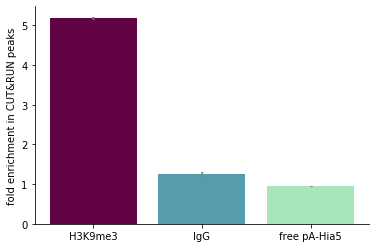

In [32]:
fig, ax1 = plt.subplots()
error = [data['mA/A in peak target over mA/A in non-target (outside peak + 10kb)'] - data['ci_ratio_lower'], data['ci_ratio_upper'] - data['mA/A in peak target over mA/A in non-target (outside peak + 10kb)']]
plt.bar('target','mA/A in peak target over mA/A in non-target (outside peak + 10kb)', data=data, yerr=error, color=cmap, ecolor='grey', capsize=1);
sns.despine(fig)
plt.ylabel('fold enrichment in CUT&RUN peaks');
plt.xlabel('')
plt.savefig(out + '/enrich_cutrun.png', dpi=300)

In [10]:
data['ci_cen'] = data.apply(lambda row : calculate_ci(row['total A genome-wide'], row['total A in centromeres'], row['total A in centromeres'], 
                                     row['mA genome-wide'], row['mA in centromeres'], row['mA in centromeres']), axis=1)

2.3505205227399673
1.1117996791488047
0.7627540977059988


In [11]:
data['ci_hor'] = data.apply(lambda row : calculate_ci(row['total A genome-wide'], row['total A in HOR'], row['total A in centromeres'], 
                                     row['mA genome-wide'], row['mA in HOR'], row['mA in centromeres']), axis=1)

4.432101538935186
1.0078769742348226
0.2661058484594046


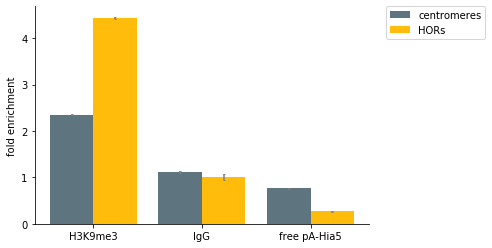

In [61]:
data['ci_ratio_lower_cen'] = [item[0] for item in data['ci_cen']]
data['ci_ratio_upper_cen'] = [item[1] for item in data['ci_cen']]
data['ci_ratio_lower_hor'] = [item[0] for item in data['ci_hor']]
data['ci_ratio_upper_hor'] = [item[1] for item in data['ci_hor']]
cmap2 = ['#5E747F', '#FFBC0A']
fig, ax1 = plt.subplots()
tidy = data.melt(id_vars='target').rename(columns=str.title)
tidy_small = tidy[(tidy['Variable'] == 'mA/A in HOR over mA/A outside centromeres') |
    (tidy['Variable'] == 'mA/A in centromere over mA/A genome-wide')]

error_cen = [data['mA/A in centromere over mA/A genome-wide'] - data['ci_ratio_lower_cen'], data['ci_ratio_upper_cen'] - data['mA/A in centromere over mA/A genome-wide']]
error_hor = [data['mA/A in HOR over mA/A outside centromeres'] - data['ci_ratio_lower_hor'], data['ci_ratio_upper_hor'] - data['mA/A in HOR over mA/A outside centromeres']]

barWidth = 0.4

bars1 = data['mA/A in centromere over mA/A genome-wide']
bars2 = data['mA/A in HOR over mA/A outside centromeres']

r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]

plt.bar(r1, bars1, yerr=error_cen, color='#5E747F', ecolor='grey', capsize=1, label='centromeres', width=barWidth);
plt.bar(r2, bars2, yerr=error_hor, color='#FFBC0A', ecolor='grey', capsize=1, label='HORs', width=barWidth);
 
# Add xticks on the middle of the group bars
plt.xticks([r + barWidth/2 for r in range(len(bars1))], data['target'])
 
# Create legend & Show graphic
sns.despine(fig)
plt.ylabel('fold enrichment')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.savefig(out + '/enrich_cen.png', dpi=300)

## CTCF

In [14]:
data_ctcf = pd.read_csv('ctcf_enrich.csv')
data_ctcf.head()

,sample #,target,cell type,total A genome-wide,total A in chip/cut&run peaks,mA genome-wide,mA in chip/cut&run,mA/A genome-wide,mA/A in chip/cut&run,mA/A in target over mA/A not in peaks
0,4,CTCF,GM12878,1656892198,6400273,2219846,171620,0.001340,0.026814,21.608
1,5,IgG,GM12878,1472043472,5724871,109963,1822,0.000075,0.000318,4.315
2,6,free pA-Hia5,GM12878,1440077917,5607119,4243776,101695,0.002947,0.018137,6.281


In [15]:
out_ctcf = 'out'

In [16]:
data_ctcf.columns

Index(['sample #', 'target', 'cell type', 'total A genome-wide',
       'total A in chip/cut&run peaks', 'mA genome-wide', 'mA in chip/cut&run',
       'mA/A genome-wide', 'mA/A in chip/cut&run',
       'mA/A in target over mA/A not in peaks'],
      dtype='object')

In [19]:
data_ctcf['ci'] = data_ctcf.apply(lambda row : calculate_ci(row['total A genome-wide'], row['total A in chip/cut&run peaks'], row['total A in chip/cut&run peaks'], 
                                     row['mA genome-wide'], row['mA in chip/cut&run'], row['mA in chip/cut&run']), axis=1)

21.607520207760043
4.315395756540256
6.281060137968503


In [20]:
data_ctcf['ci_ratio_lower'] = [item[0] for item in data_ctcf['ci']]
data_ctcf['ci_ratio_upper'] = [item[1] for item in data_ctcf['ci']]

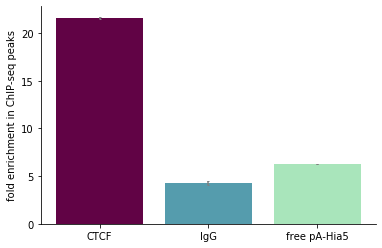

In [24]:
fig, ax1 = plt.subplots()

error = [data_ctcf['mA/A in target over mA/A not in peaks'] - data_ctcf['ci_ratio_lower'], data_ctcf['ci_ratio_upper'] - data_ctcf['mA/A in target over mA/A not in peaks']]
plt.bar('target','mA/A in target over mA/A not in peaks', data=data_ctcf, yerr=error, color=cmap, ecolor='grey', capsize=1);
sns.despine(fig)

plt.ylabel('fold enrichment in ChIP-seq peaks');
plt.xlabel('')
plt.savefig(out_ctcf + '/enrich_chip.png', dpi=300)